# Iterative proportional Fitting (aka ranking) algorithm 


## Often with a design of experiments, the effect of a treatment (vs control) could be measured using randomised control trails. However, it might not always be feasible to divide traffic/users/devices/entities in this manner.  


* The outcome/target/metric could be driven by treatment vs control differences. Besides this, there could be other dimensions which could affect the outcome - exogenous effect variables


* In some cases there might be "endogenous / confounder variables". 


* In such instances, one coule follow a few matching/propensity-scoring techniques such that, the effect of treatment vs difference can be measured, " after accounting for the exogenous effect and endogenous confounder variables/dimensions.


* For many linear problems, the econometric modeling methods such as ANOVA/ANCOVA can be used [linear models] . Or more advancements in recent decade, such as counter factual techniques, conditional average treatment effect (CATE) methods could be applied. 


* In your armour of techniques, add iterative proportional fitting method too. 





**KEY POINTS **
- It is simple, efficient, can be used to match unconventional distributions. 
- It can be used to match non-parameteric, discretised distributions of features in the sample. 
- You may not know the joint distribution of the features. You can try IPF to match "marginal distributions". 
- 
- Note that there might not be a "feasible set" of weights in some scenarios. 
    - For example, assume there are two dimensions which are negatively correlated (~very high). 
    - But user provides target distributions for dimension 1 and 2 such that they seem to be highly +vely correlated.
    - A "feasible set" of weights might not exist. Or the weights could be highly skewed, that a few rows in the data have very large weight and most of the rows have very small (close to zero) weight. 
    - So chose targets wisely. 


**Below notebook does following:**

* Creates targets
* Creates dummy sample

* IPF class
   - train weights 
   - compute standardized mean difference between target and simulated sample distributions [raw distributions]


In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import io, os, sys, datetime, math, random, boto3, pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib import ticker
#import tqdm.tqdm_pandas as tqdm_pandas
from tqdm.auto import tqdm
import copy

In [3]:
pd.options.display.float_format = "{:,.2f}".format
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',200)
pd.set_option('display.width',500)

In [4]:
sns.set()
tqdm.pandas()

/home/ec2-user/SageMaker/ds_sagemaker_utils/miniconda/envs/DS_py37/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


## create simulated targets 

In [5]:
dlen = 1000
t_x1 = np.random.uniform(low= 0, high = 10,size=dlen)
t_x2 = np.random.choice([0,1],size=dlen,p=[0.25, 0.75])
t_x3x4_mean = [2, 3]
t_x3x4_cov  = [[8, 3],[3, 4]]
t_x3x4      = np.random.multivariate_normal(mean=t_x3x4_mean, cov=t_x3x4_cov, size=dlen, check_valid='warn', tol=1e-8)
t_x3        = t_x3x4[:,0]
t_x4        = t_x3x4[:,1]

t_rvars = [t_x1 , t_x2, t_x3, t_x4]
t_bvars = [] 
t_bvars.append(np.round(t_x1,0).astype(np.int32))
t_bvars.append(np.round(t_x2,0).astype(np.int32))

target_bins = [np.array(0), np.array(0)] 
target_bins.append(np.quantile(t_x3, np.linspace(0.1,0.9,9)))
target_bins.append(np.quantile(t_x4, np.linspace(0.1,0.9,9)))
t_bvars.append(np.digitize(t_x3 ,target_bins[2],right=True))
t_bvars.append(np.digitize(t_x4 ,target_bins[3],right=True))

t_bdist = []
for i, v in enumerate(t_bvars):
    _i1, _i2 = np.unique(v, return_counts=True)
    _dict = {}
    for k, v in zip(_i1, _i2):
        _dict[k] = v
    t_bdist.append(_dict)

i is 0 , v is {0: 49, 1: 103, 2: 100, 3: 99, 4: 96, 5: 106, 6: 102, 7: 109, 8: 97, 9: 86, 10: 53} 
i is 1 , v is {0: 253, 1: 747} 
i is 2 , v is {0: 100, 1: 100, 2: 100, 3: 100, 4: 100, 5: 100, 6: 100, 7: 100, 8: 100, 9: 100} 
i is 3 , v is {0: 100, 1: 100, 2: 100, 3: 100, 4: 100, 5: 100, 6: 100, 7: 100, 8: 100, 9: 100} 


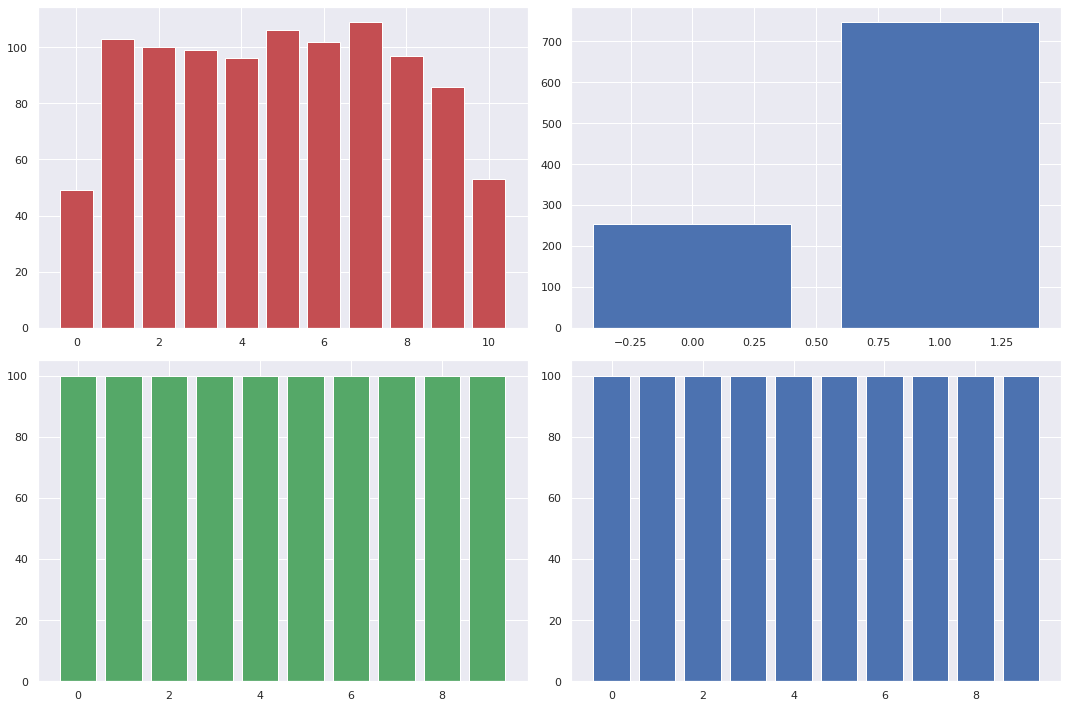

In [6]:
fig, ax = plt.subplots(2,2,figsize=(15,10),tight_layout=True)
cl = ['r','b','g','b']

for i, v in enumerate(t_bdist):
     print(f"i is {i} , v is {v} ")
     ax[int(i/2), i%2].bar(np.fromiter(v.keys()  , dtype=np.int32), 
                           np.fromiter(v.values(), dtype=np.int32), color=cl[i])

In [7]:
t_bdist_pct = []
for i, var in enumerate(t_bdist):
    _dd = {}
    for k, val in var.items():
         _dd[k] = val/sum(var.values())
    t_bdist_pct.append(_dd)

## simulated data

In [8]:
dlen = 1000
x1 = np.random.uniform(low= 0, high = 10,size=dlen)
x2 = np.random.uniform(low= 0, high = 1 ,size=dlen)
x3x4_mean = [0.5, 5]
x3x4_cov  = [[10, 5],[5, 8]]
x3x4      = np.random.multivariate_normal(mean=x3x4_mean, cov=x3x4_cov, size=dlen, check_valid='warn', tol=1e-8)
x3        = x3x4[:,0]
x4        = x3x4[:,1]


In [9]:
rvars = [x1  , x2 , x3, x4]
bvars = [] 
bvars.append(np.round(x1,0).astype(np.int32))
bvars.append(np.round(x2,0).astype(np.int32))
bvars.append(np.digitize(x3 ,target_bins[2],right=True))
bvars.append(np.digitize(x4 ,target_bins[3],right=True))

bdist = []
for i, v in enumerate(bvars):
    _i1, _i2 = np.unique(v, return_counts=True)
    _dict = {}
    for k, v in zip(_i1, _i2):
        _dict[k] = v
    bdist.append(_dict)

i is 0 , v is {0: 44, 1: 90, 2: 101, 3: 97, 4: 87, 5: 105, 6: 115, 7: 105, 8: 110, 9: 96, 10: 50} 
i is 1 , v is {0: 519, 1: 481} 
i is 2 , v is {0: 241, 1: 145, 2: 110, 3: 80, 4: 87, 5: 82, 6: 80, 7: 67, 8: 63, 9: 45} 
i is 3 , v is {0: 59, 1: 37, 2: 44, 3: 37, 4: 47, 5: 46, 6: 62, 7: 84, 8: 131, 9: 453} 


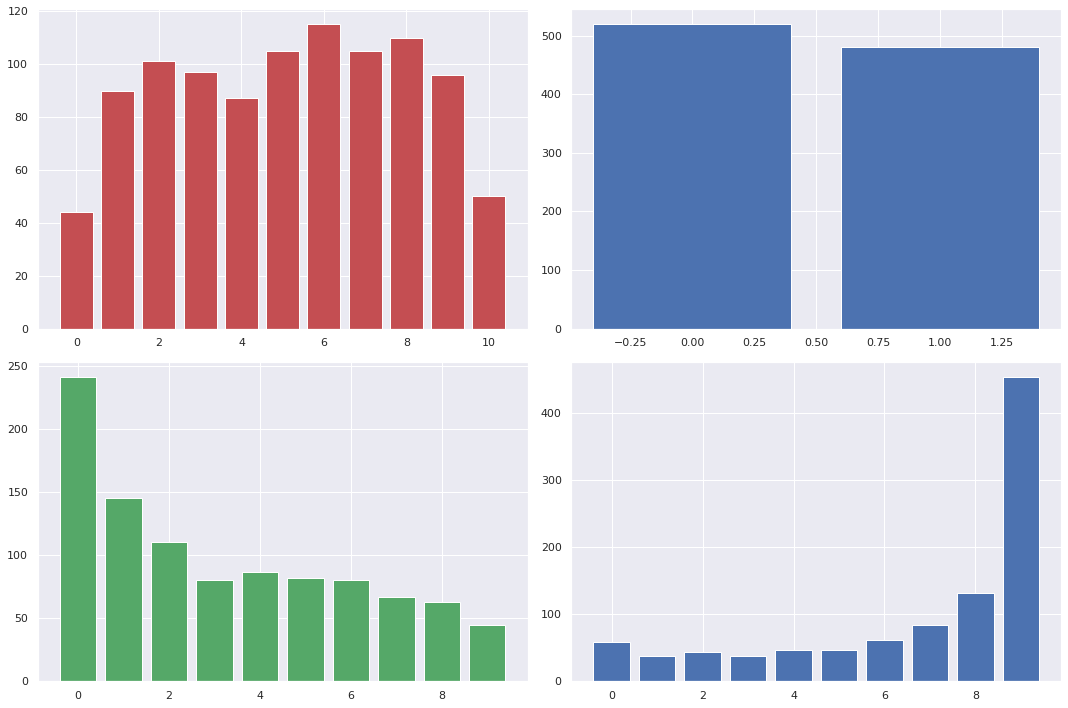

In [10]:
fig, ax = plt.subplots(2,2,figsize=(15,10),tight_layout=True)
cl = ['r','b','g','b']
for i, v in enumerate(bdist):
     print(f"i is {i} , v is {v} ")
     #sns.barplot(x=v.keys(), y=v.values(), ax=ax[int(i/2), i%2])
     ax[int(i/2), i%2].bar(np.fromiter(v.keys()  , dtype=np.int32), 
                           np.fromiter(v.values(), dtype=np.int32), color=cl[i])

# Iterative proportional fitting class 

In [29]:
class ipf_class():
    def __init__(self, max_iterations, min_gap_threshold, raw_varcols=None, raw_targetcols=None, 
                         binned_vars, target_binnedvar_dist, vnames):
         self.max_iterations    = max_iterations
         self.min_gap_threshold = min_gap_threshold
         self.bvars             = binned_vars 
         self.t_bdist_pct       = target_binnedvar_dist    
         self.raw_varcols       = raw_varcols
         self.raw_targetcols    = raw_targetcols
         self.actual_gap_t_vs_a = 99999
         self.iternum           = 0
         self.NUM_DIMS          = len(self.bvars)
         self.weights           = np.ones(len(self.bvars[0])) 
         self.actual_dist       = []
         self.wtd_dist          = []
         self.vnames            = vnames

    def vectorize_wt_multiliers(self, ar, ddic):
        _k = np.array(list(ddic.keys()))
        _v = np.array(list(ddic.values()))

        sx = _k.argsort()
        _k = _k[sx]
        _v = _v[sx]
        return _v[np.searchsorted(_k,ar)]

    def wtd_count_compute(self, ar, wts):
        wtd_dist = {}
        for i in np.unique(ar):
            wtd_dist[i] = np.where((ar==i),wts, wts*0).sum()/wts.sum()
        return wtd_dist

    def compute_deviation(self, t, a):
        assert len(t) == len(a), "Length of distribution lists should be identical"
        sum_gap = 0
        for i, a_dict in enumerate(a):
            t_dict = t[i]
            assert len(a_dict.keys()) == len(t_dict.keys()), "For every value in variable there should be a target and  every value in target dist should be in the dataset "
            sum_gap += sum([(t_dict.get(k, 0)- v)**2 for k, v in a_dict.items() ])
        return sum_gap

    def train(self):
        self.iternum           = 0
        self.actual_gap_t_vs_a = 99999
        while ((self.actual_gap_t_vs_a >self.min_gap_threshold) & (self.iternum<self.max_iterations)):
            for vid in range(self.NUM_DIMS):
                __dnew = self.wtd_count_compute(ar=self.bvars[vid], wts=self.weights)
                mult_map = {}
                for k,v in self.t_bdist_pct[vid].items():
                     mult_map[k] = max(v,0.001)/__dnew.get(k,0.001)

                self.weights = np.multiply(self.weights.astype(np.float), self.vectorize_wt_multiliers(self.bvars[vid], mult_map).astype(np.float))

            self.actual_dist_old = copy.deepcopy(self.actual_dist)
            self.actual_dist     = []
            for vid in range(self.NUM_DIMS):
                self.actual_dist.append(self.wtd_count_compute(ar=self.bvars[vid], wts=self.weights))

            #print(f"{len(t_bdist_pct)} , {len()})
            self.actual_gap_t_vs_a = self.compute_deviation(self.t_bdist_pct, self.actual_dist)
            print(f"Iternum - {self.iternum} , actual_gap_t_vs_a - {round(self.actual_gap_t_vs_a,4)} ")
            self.iternum +=1
        self.compute_wtd_dist()
        self.compute_smd()

    def compute_wtd_dist(self):
        self.wtd_dist = []
        for vid in range(self.NUM_DIMS):
            self.wtd_dist.append(self.wtd_count_compute(ar=self.bvars[vid], wts=self.weights))

    def smd(self, a, wts, t):
        avg1 = np.average(a, weights=wts)
        var1 = np.average((a-avg1)**2, weights=wts)
        avg2 = np.average(t)
        var2 = np.average((t-avg2)**2)
        return (avg1 - avg2) / np.sqrt(var1+var2)

    def compute_smd(self):
        if self.raw_varcols !=None:
            stats = []
            for i, v in enumerate(self.raw_varcols):
                stats.append([i, self.vnames[i], self.smd(v, self.weights, self.raw_targetcols[i])])
            self.smd_statsdf = pd.DataFrame(stats, columns=['idx','varname','SMD'])
        else:
            print('pass original variables [undiscretised] from sample and target datasets ')
    

## Raking/IPF  - initialize & train

In [30]:
ipfobj = ipf_class(max_iterations        = 200, 
                   min_gap_threshold     = 0.001, 
                   raw_varcols           = rvars, 
                   raw_targetcols        = t_rvars, 
                   binned_vars           = bvars, 
                   target_binnedvar_dist = t_bdist_pct,
                   vnames                = 'x1 x2 x3 x4'.split())


In [31]:
ipfobj.train()

Iternum - 0 , actual_gap_t_vs_a - 0.0259 
Iternum - 1 , actual_gap_t_vs_a - 0.0029 
Iternum - 2 , actual_gap_t_vs_a - 0.0004 


## Compare wtd distributions 

i is 0 , v is {0: 0.04796874542371157, 1: 0.09809805974234412, 2: 0.09403309415766398, 3: 0.09458658456288624, 4: 0.10659908065052566, 5: 0.10921268633492334, 6: 0.10306494578425564, 7: 0.10475441534628485, 8: 0.09618005403747884, 9: 0.08928438061988993, 10: 0.056217953340035876} 
i is 1 , v is {0: 0.2575473364531445, 1: 0.7424526635468555} 
i is 2 , v is {0: 0.10627728090623606, 1: 0.10417059590387565, 2: 0.10269067243810767, 3: 0.10438541870752599, 4: 0.09991408092128498, 5: 0.09912869985046768, 6: 0.09677373893037901, 7: 0.095112004841242, 8: 0.0965870768488519, 9: 0.09496043065202901} 
i is 3 , v is {0: 0.1, 1: 0.1, 2: 0.1, 3: 0.09999999999999998, 4: 0.1, 5: 0.10000000000000002, 6: 0.1, 7: 0.09999999999999999, 8: 0.1, 9: 0.1} 


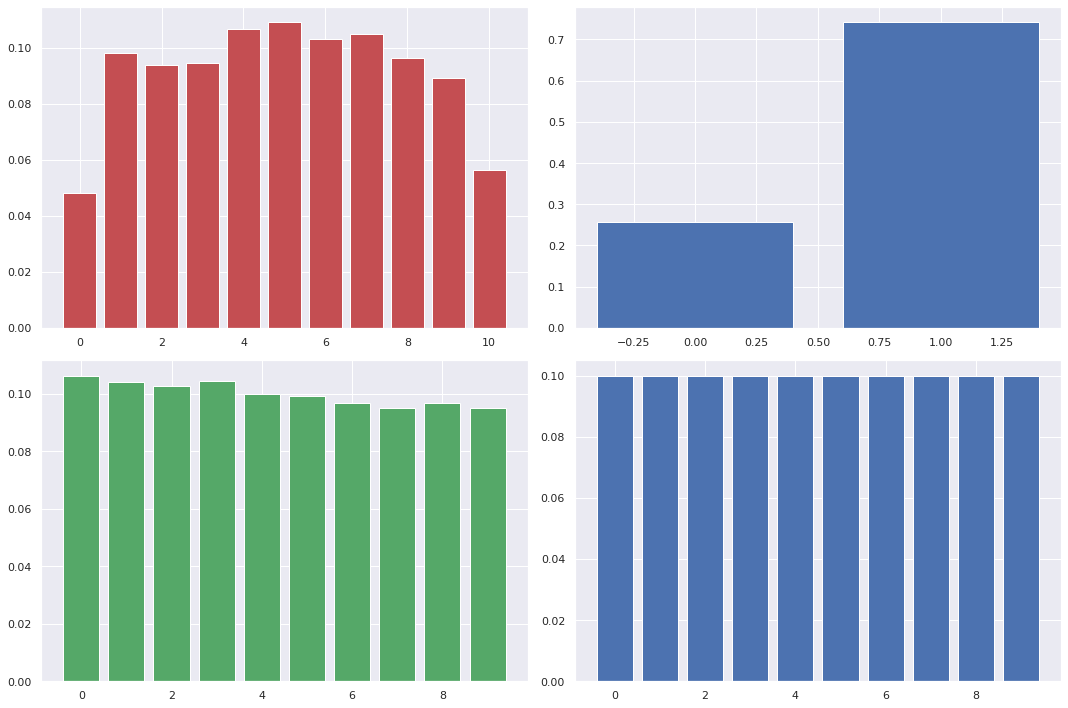

In [32]:
fig, ax = plt.subplots(2,2,figsize=(15,10),tight_layout=True)
cl = ['r','b','g','b']
for i, v in enumerate(ipfobj.wtd_dist):
     print(f"i is {i} , v is {v} ")
     #sns.barplot(x=v.keys(), y=v.values(), ax=ax[int(i/2), i%2])
     ax[int(i/2), i%2].bar(np.fromiter(v.keys()  , dtype=np.int32), 
                           np.fromiter(v.values(), dtype=np.float), color=cl[i])

# Compute standardized mean difference between sample and target data distribution [raw features] 

In [ ]:
ipfobj.compute_smd()

In [33]:
ipfobj.smd_statsdf

,idx,varname,SMD
0,0,x1,0.01
1,1,x2,-0.23
2,2,x3,-0.07
3,3,x4,0.05
